# Variance matters

In [ ]:
!pip install --upgrade pip
!pip install pymc>=5 --quiet
!pip install patsy --quiet
!pip install graphviz --quiet
!pip install tables --quiet
!pip install seaborn --quiet
!pip install bambi --quiet
!pip install CRPS --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1


In [ ]:
import numpy as np
import pandas as pd
import patsy as pt
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import bambi
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from dataclasses import dataclass
from abc import abstractmethod
from CRPS import CRPS

/root/venv/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/root/venv/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
# Parameters that will be used by models
DRAWS = 500
TUNE = 500
CHAINS = 2

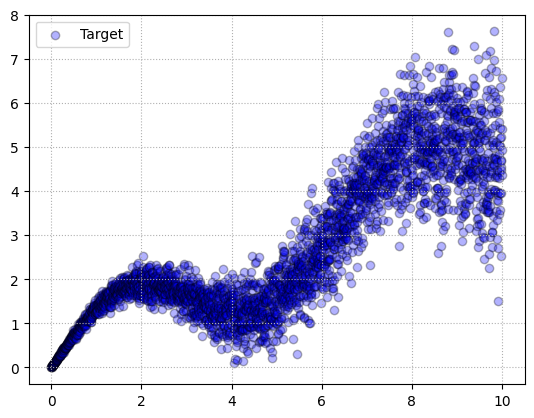

In [ ]:
# Create some data
N = 3000
x = np.linspace(0, 10, N)
y_ground_truth =  .5*x + np.sin(x)
y = y_ground_truth + np.random.randn(N)*x/10

plt.scatter(x=x, y=y, color='blue', edgecolors='k', alpha=0.3, label='Target')
plt.grid(linestyle=':')
plt.legend()

In [ ]:
def x_to_spline(x, n_knots: int = 10) -> pd.DataFrame:
    '''Build splines on x space'''

    knots = np.linspace(-.1, 10.1, n_knots)
    x_dummy  = np.concatenate((x, [-0.1, 10.1]), axis=0)
    spline_basis = pt.dmatrix("bs(x, knots=knots, degree=3, include_intercept=True) - 1", {"x": x_dummy, "knots": knots})
    spline_basis = spline_basis[:-2, :] # Remove dummy variables

    spline_basis_df = pd.DataFrame(spline_basis, index=x)
    return spline_basis_df

<AxesSubplot: title={'center': 'Spline basis'}>

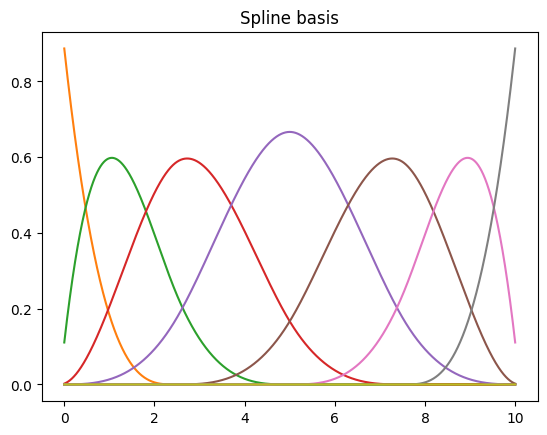

In [ ]:
# Build spline basis
N_KNOTS = 5
X_spline = x_to_spline(x, n_knots=N_KNOTS)

X_spline.sort_index().plot(legend=False, title='Spline basis')

# Models
The models I'm going to compare are very similar to each other. All of them consist in a normal distribution in which mean and variance will be described by a combination of splines.

Priors will be assigned to splines coefficients to both mean and variance depending on the model (see below for details).
 
The purpose of this notebook is to show two methodology to model variance and impact on performance w.r.t. a model with constant variance.


## Model 1

Simple model with mean dependent on $x$ and constant variance.

$$
y  \sim \mathcal{N}(\mu(x), \sigma)
$$

$$
m(x) = Spline(x) \cdot \beta + c
$$

$$
\beta \sim \mathcal{N}(0, 1) ^ n
$$

$$
c \sim \mathcal{N}(0, 1)
$$

$$
\sigma \sim \mathcal{HN}(0, 1)
$$

## Model 2

Spline modeling variance is by costruction always positive to avoid issue in sampling phase

$$
y  \sim \mathcal{N}(\mu(x), \sigma(x))
$$

$$
m(x) = Spline(x) \cdot \beta_\mu + c_\mu
$$

$$
\sigma(x) = Spline(x) \cdot \beta_\sigma + c_\sigma
$$

$$
\beta_\mu \sim \mathcal{N}(0, 1) ^ n
$$

$$
c_\mu \sim \mathcal{N}(0, 1)
$$

$$
\beta_\sigma \sim \mathcal{HN}(0, 1) ^ n
$$

$$
c_\sigma \sim \mathcal{HN}(0, 1)
$$

## Model 3

Spline modelling variance $\sigma(x)$ can assume negative values but in that case an huge penalization is applied to the likelihood.

$$
y  \sim \mathcal{N}(\mu(x), \sigma(x)) + \mathcal{P}(\sigma(x))
$$

$$
m(x) = Spline(x) \cdot \beta_\mu + c_\mu
$$

$$
\sigma(x) = Spline(x) \cdot \beta_\sigma + c_\sigma
$$

$$
\mathcal{P}(\sigma(x)) = -P \cdot \mathcal{1}_{\sigma(x) < 0 } \hspace{0.5cm} P\gg1
$$

$$
\beta_\mu \sim \mathcal{N}(0, 1) ^ n
$$

$$
c_\mu \sim \mathcal{N}(0, 1)
$$

$$
\beta_\sigma \sim \mathcal{N}(0, 1) ^ n
$$

$$
c_\sigma \sim \mathcal{N}(0, 1)
$$

In [ ]:
@dataclass
class BaseSplineModel():

    def __post_init__(self):
        self._model = pm.Model()
        self.trace = None

    def plot_trace(self, ax=None):
        _ = az.plot_trace(data=self.trace, axes=ax)
        plt.tight_layout()


    def plot_ppc(self, n_pp_samples: int = 100, ax=None):
        az.plot_ppc(self.trace, num_pp_samples=n_pp_samples, ax=ax)
        plt.tight_layout()


    @abstractmethod
    def fit(X, y):
        raise NotImplementedError('Missing fit')

    @abstractmethod
    def predict(X, sample_kwargs  = {}):
        raise NotImplementedError('Missing predict')


@dataclass
class SplineModel1(BaseSplineModel):

    def fit(self, X, y,  avi: bool = False):
        with self._model:


            X_mutable = pm.MutableData('X', X)
        

            beta_mu = pm.Normal('beta_mu', mu=0, sigma=1, shape=X_mutable.shape[1])
            c_mu = pm.Normal('c_mu', mu=0, sigma=1)
            mu = pm.Deterministic('mu', pm.math.dot(X_mutable, beta_mu) + c_mu)


            sigma = pm.HalfNormal('sigma', sigma=1)


            y_obs = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)
            
            if avi:
                approx = pm.fit()
                self.trace = approx.sample()
            else:
                self.trace = pm.sample(draws=DRAWS, chains=CHAINS,  cores=4, tune=TUNE)
            ppc = pm.sample_posterior_predictive(self.trace, extend_inferencedata=True)

    def predict(self, X):
        with self._model:
            pm.set_data({'X': X})
            ppc = pm.sample_posterior_predictive(self.trace)
            return ppc
    
    def plot_trace(self, ax=None):
        _ = az.plot_trace(data=self.trace, var_names=['beta_mu', 'c_mu', 'sigma'], axes=ax)
        plt.tight_layout()


@dataclass
class SplineModel2(BaseSplineModel):

    def fit(self, X, y, avi: bool = False):
        with self._model:

            X_mutable = pm.MutableData('X', X)
        
            beta_mu = pm.Normal('beta_mu', mu=0, sigma=1, shape=X_mutable.shape[1])
            c_mu = pm.Normal('c_mu', mu=0, sigma=1)
            beta_sigma = pm.HalfNormal('beta_sigma', sigma=1, shape=X_mutable.shape[1])
            c_sigma = pm.HalfNormal('c_sigma', sigma=1)

            mu = pm.Deterministic('mu', pm.math.dot(X_mutable, beta_mu) + c_mu)
            sigma = pm.Deterministic('sigma', pm.math.dot(X_mutable, beta_sigma) + c_sigma)
            
            y_obs = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)
        
            if avi:
                approx = pm.fit()
                self.trace = approx.sample()
            else:
                self.trace = pm.sample(draws=DRAWS, chains=CHAINS,  cores=4, tune=TUNE)
            ppc = pm.sample_posterior_predictive(self.trace, extend_inferencedata=True)

    def predict(self, X):
        with self._model:
            pm.set_data({'X': X})
            ppc = pm.sample_posterior_predictive(self.trace)
            return ppc

    def plot_trace(self, ax=None):
        _ = az.plot_trace(data=self.trace, var_names=['beta_mu', 'c_mu', 'beta_sigma', 'c_sigma'], axes=ax)
        plt.tight_layout()


@dataclass
class SplineModel3(BaseSplineModel):

    def fit(self, X, y, avi: bool = False):
        with self._model:
            X_mutable = pm.MutableData('X', X)
        
            beta_mu = pm.Normal('beta_mu', mu=0, sigma=10, shape=X_mutable.shape[1])
            c_mu = pm.Normal('c_mu', mu=0, sigma=10)
            beta_sigma = pm.Normal('beta_sigma', mu=0, sigma=10, shape=X_mutable.shape[1])
            c_sigma = pm.Normal('c_sigma', mu=0, sigma=10)

            mu = pm.Deterministic('mu', pm.math.dot(X_mutable, beta_mu) + c_mu)
            sigma = pm.Deterministic('sigma', pm.math.dot(X_mutable, beta_sigma) + c_sigma)

            penalty = pm.Potential('penalty', pm.math.switch(pm.math.dot(X_mutable, beta_sigma) + c_sigma<0, -999999999999, 0))
            
            y_obs = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)


            if avi:
                approx = pm.fit()
                self.trace = approx.sample()
            else:
                self.trace = pm.sample(draws=DRAWS, chains=CHAINS, cores=4, tune=TUNE)
            ppc = pm.sample_posterior_predictive(self.trace, extend_inferencedata=True)

    def predict(self, X):
        with self._model:
            pm.set_data({'X': X})
            ppc = pm.sample_posterior_predictive(self.trace)
            return ppc


    def plot_trace(self, ax=None):
        _ = az.plot_trace(data=self.trace, var_names=['beta_mu', 'c_mu', 'beta_sigma', 'c_sigma'], axes=ax)
        plt.tight_layout()

In [ ]:
mdl1 = SplineModel1()
mdl1.fit(X_spline, y, avi=False)

mdl2 = SplineModel2()
mdl2.fit(X_spline, y, avi=False)

mdl3 = SplineModel3()
mdl3.fit(X_spline, y, avi=False)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta_mu, c_mu, sigma]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 598 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [likelihood]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta_mu, c_mu, beta_sigma, c_sigma]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 4403 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [likelihood]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta_mu, c_mu, beta_sigma, c_sigma]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3914 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/tmp/ipykernel_37/1738079414.py:126: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace, extend_inferencedata=True)
Sampling: [likelihood]


# Posterior checks

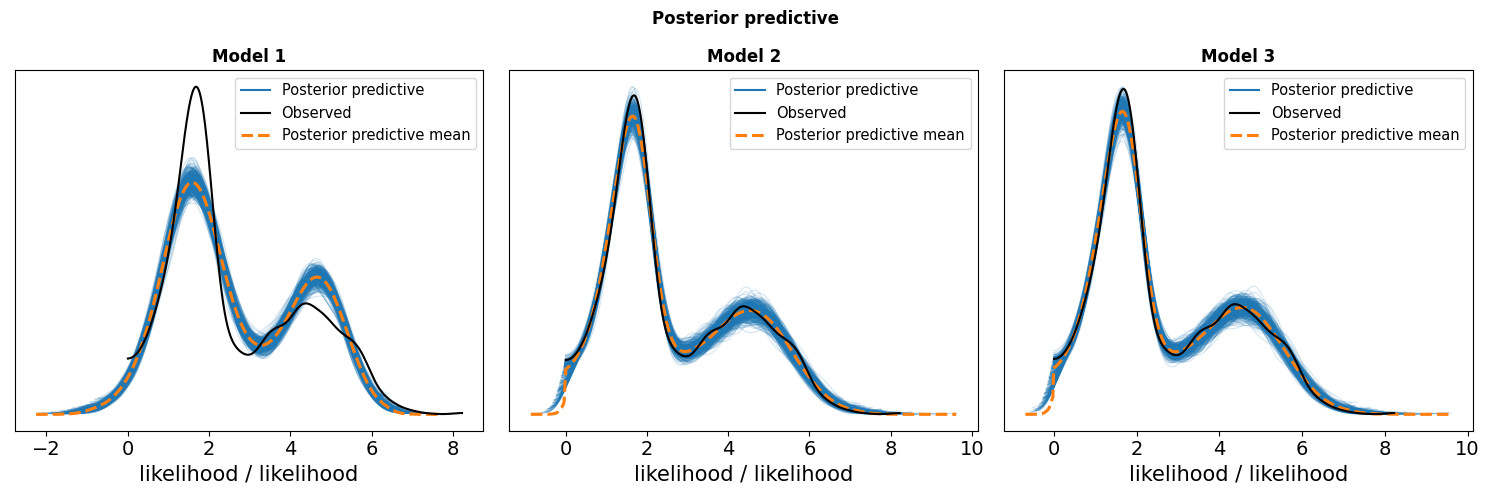

KernelInterrupted: Execution interrupted by the Jupyter kernel.

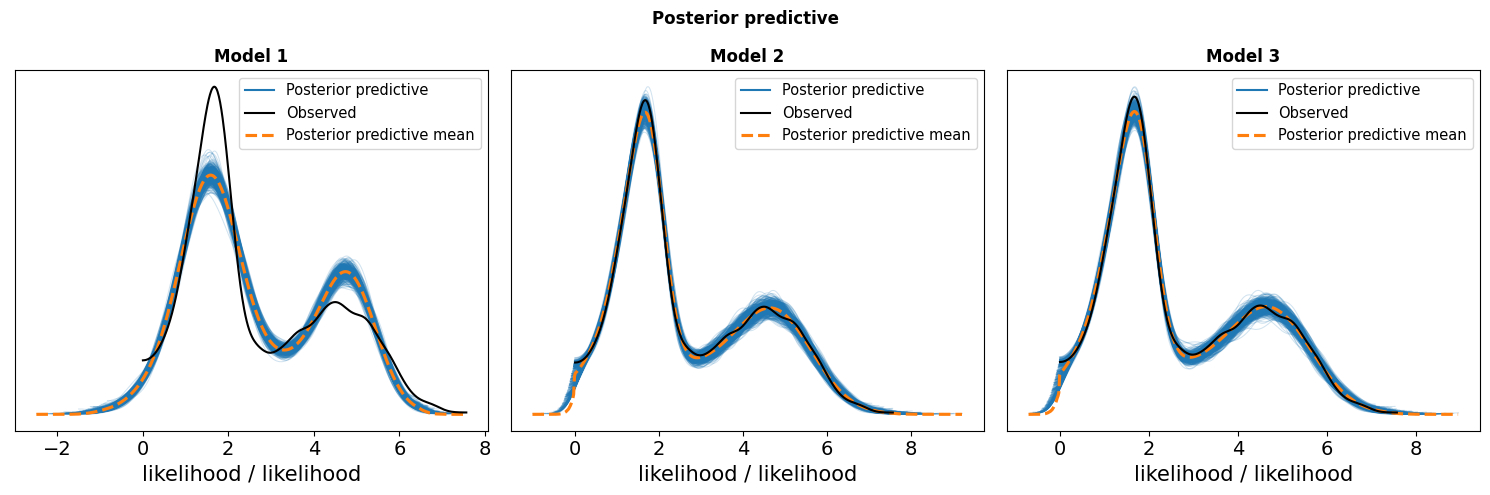

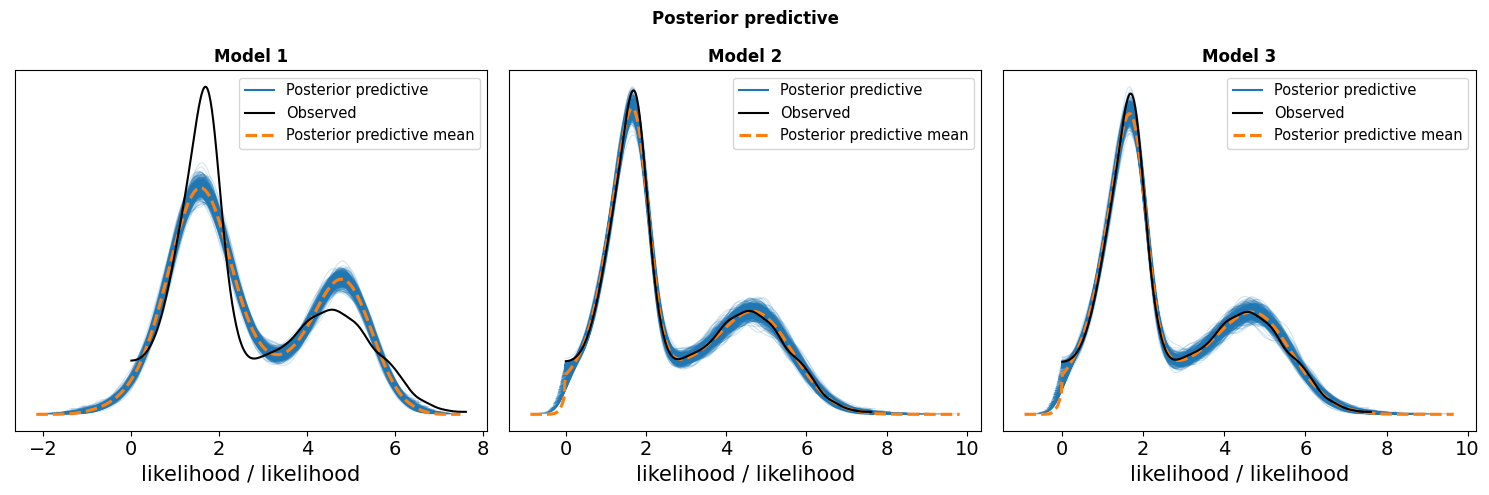

In [ ]:
# Visualize Posterior predictive
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Posterior predictive', fontweight='bold')
mdl1.plot_ppc(n_pp_samples=500, ax=ax[0])
mdl2.plot_ppc(n_pp_samples=500, ax=ax[1])
mdl3.plot_ppc(n_pp_samples=500, ax=ax[2])
ax[0].set_title('Model 1', fontweight='bold')
ax[1].set_title('Model 2', fontweight='bold')
ax[2].set_title('Model 3', fontweight='bold')
plt.tight_layout()

In [ ]:
# Compute inference

# ------------- MODEL 1
mean1 = mdl1.predict(X_spline).posterior_predictive.likelihood.mean(dim=['chain', 'draw']).values
quantile1 = mdl1.predict(X_spline).posterior_predictive.likelihood.quantile(q=[.1, .9], dim=['chain', 'draw']).values.T

y_pred_1 = pd.DataFrame(index=x, columns = ['mean', 'p10', 'p90'])
y_pred_1['mean'] = mean1
y_pred_1[['p10', 'p90']] = quantile1
y_pred_1.sort_index(inplace=True)


# ------------- MODEL 2
mean2 = mdl2.predict(X_spline).posterior_predictive.likelihood.mean(dim=['chain', 'draw']).values
quantile2 = mdl2.predict(X_spline).posterior_predictive.likelihood.quantile(q=[.1, .9], dim=['chain', 'draw']).values.T

y_pred_2 = pd.DataFrame(index=x, columns = ['mean', 'p10', 'p90'])
y_pred_2['mean'] = mean2
y_pred_2[['p10', 'p90']] = quantile2
y_pred_2.sort_index(inplace=True)


# ------------- MODEL 3
mean3 = mdl3.predict(X_spline).posterior_predictive.likelihood.mean(dim=['chain', 'draw']).values
quantile3 = mdl3.predict(X_spline).posterior_predictive.likelihood.quantile(q=[.1, .9], dim=['chain', 'draw']).values.T

y_pred_3 = pd.DataFrame(index=x, columns = ['mean', 'p10', 'p90'])
y_pred_3['mean'] = mean3
y_pred_3[['p10', 'p90']] = quantile3
y_pred_3.sort_index(inplace=True)



Sampling: [likelihood]


Sampling: [likelihood]


Sampling: [likelihood]


Sampling: [likelihood]


/tmp/ipykernel_37/1738079414.py:131: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace)
Sampling: [likelihood]


/tmp/ipykernel_37/1738079414.py:131: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace)
Sampling: [likelihood]


Sampling: [likelihood]


Sampling: [likelihood]


Sampling: [likelihood]


Sampling: [likelihood]


/tmp/ipykernel_41/1738079414.py:131: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace)
Sampling: [likelihood]


/tmp/ipykernel_41/1738079414.py:131: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace)
Sampling: [likelihood]


Sampling: [likelihood]


Sampling: [likelihood]


Sampling: [likelihood]


Sampling: [likelihood]


/tmp/ipykernel_37/1738079414.py:131: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace)
Sampling: [likelihood]


/tmp/ipykernel_37/1738079414.py:131: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace)
Sampling: [likelihood]


Text(0.5, 0.98, 'Inference and quantiles')

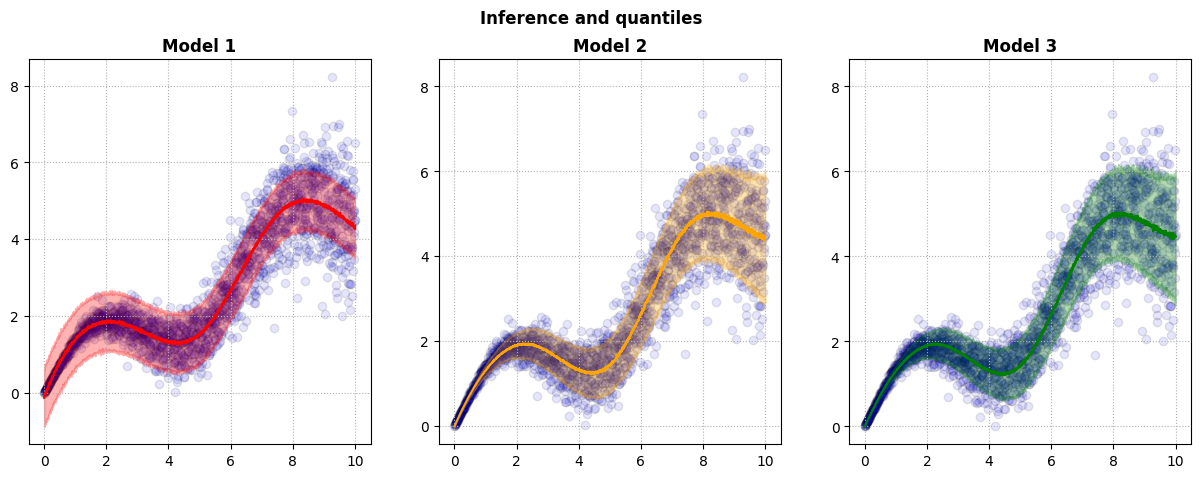

Text(0.5, 0.98, 'Inference and quantiles')

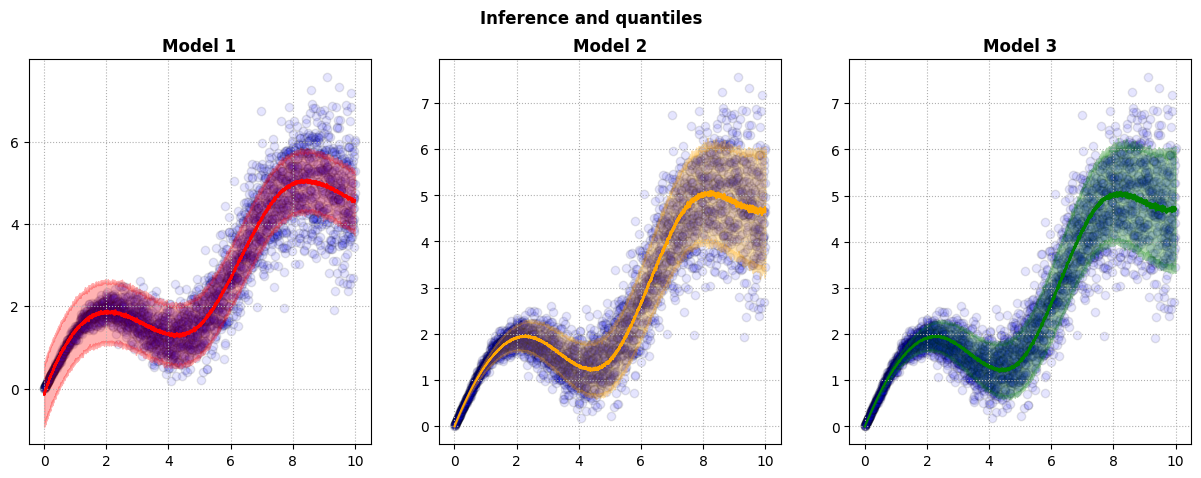

Text(0.5, 0.98, 'Inference and quantiles')

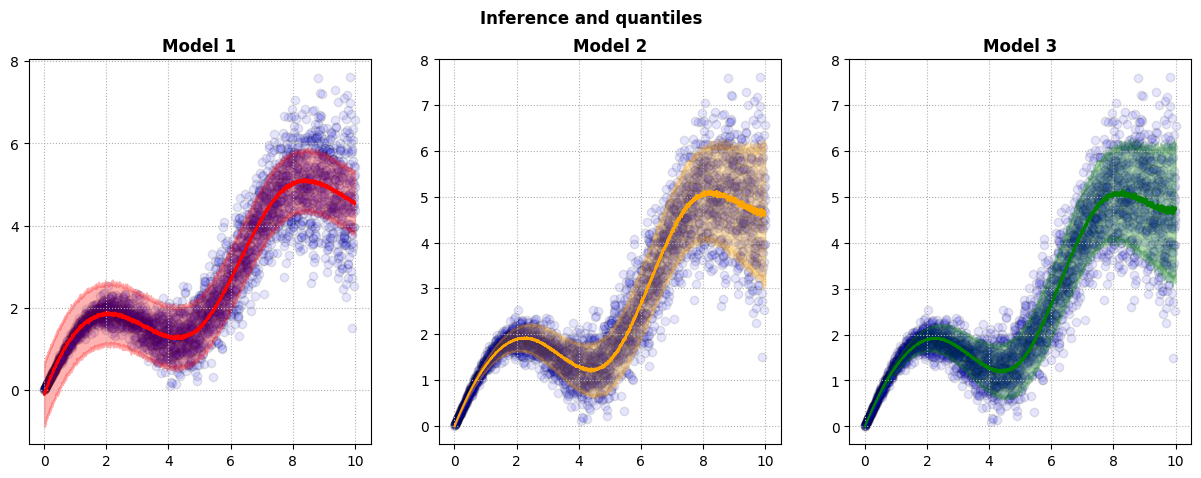

In [ ]:
# Visualize confidence interval
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
ax[0].scatter(x=x, y=y, color='blue', edgecolors='k', alpha=0.1, label='Train')
ax[0].plot(y_pred_1.index, y_pred_1['mean'], color='red', label='Model 1')
ax[0].fill_between(x=y_pred_1.index, y1=y_pred_1['p10'], y2=y_pred_1['p90'], color='red', alpha=.3)
ax[0].grid(linestyle=":")
ax[0].set_title('Model 1', fontweight='bold')

ax[1].scatter(x=x, y=y, color='blue', edgecolors='k', alpha=0.1, label='Train')
ax[1].plot(y_pred_2.index, y_pred_2['mean'], color='orange', label='Model 2')
ax[1].fill_between(x=y_pred_2.index, y1=y_pred_2['p10'], y2=y_pred_2['p90'], color='orange', alpha=.3)
ax[1].grid(linestyle=":")
ax[1].set_title('Model 2', fontweight='bold')


ax[2].scatter(x=x, y=y, color='blue', edgecolors='k', alpha=0.1, label='Train')
ax[2].plot(y_pred_3.index, y_pred_3['mean'], color='green', label='Model 3')
ax[2].fill_between(x=y_pred_3.index, y1=y_pred_3['p10'], y2=y_pred_2['p90'], color='green', alpha=.3)
ax[2].grid(linestyle=":")
ax[2].set_title('Model 3', fontweight='bold')

fig.suptitle('Inference and quantiles', fontweight='bold')



# Metrics
When valuating distributional output one of the main metric is the **Continous Ranked Probability Score**. Let $y$ the target and a $f_x$ distributional model output given the correspondent value of regressor $x$. Let $F_x$ the CDF fof $f_x$:

$$
F_x(\alpha) = \int_{-\infty}^\alpha f_x(p) \, dp
$$

We define CPRS as:

$$
CRPS(y, f(x)) = \int_\mathbb{R} \| F_x(p) - H_y(p)  \|^2 \, d\xi 
$$

where $H_y$ is the Heaviside function centered in $y$.

This metric is nothing but the $L^2$ distance between the CDF of the model output and the CDF of the groud truth.

In this notebook I've also computed the CRPS Percentage that is nothing but a normalization of the CRPS:

$$
CRPS\% (y, f_x) = \frac{CRPS(y, f_x)}{y}
$$

In [ ]:
# Metrics

def vecCRPS(y_true, y_forecast):
    '''Return tuple containing mean of CRPS, FCRPS, ACRPS computed across all samples'''
    assert len(y_true) == y_forecast.shape[0]
    result = np.zeros((len(y_true), 3))
    for i, _ in enumerate(y_true):
        res_tmp = CRPS( y_forecast[i, :], y_true[i]).compute()
        result[i, :] = res_tmp
    return result


def vecCRPSP(y_true, y_forecast):
    '''Return tuple containing mean percentage of CRPS, FCRPS, ACRPS computed across all samples'''
    assert len(y_true) == y_forecast.shape[0]
    result = np.zeros((len(y_true), 3))
    for i, _ in enumerate(y_true):
        res_tmp = CRPS( y_forecast[i, :], y_true[i]).compute() / y_true[i]
        result[i, :] = res_tmp
    return result


def meanCRPS(y_true, y_forecast):
    '''Return tuple containing mean of CRPS, FCRPS, ACRPS computed across all samples'''
    assert len(y_true) == y_forecast.shape[0]
    result = np.zeros((len(y_true), 3))
    for i, _ in enumerate(y_true):
        res_tmp = CRPS( y_forecast[i, :], y_true[i]).compute()
        result[i, :] = res_tmp

    return np.mean(result, axis=0)


In [ ]:
pred_mdl1 = mdl1.predict(X_spline).posterior_predictive.likelihood.mean(dim=['chain']).values.T
pred_mdl2 = mdl2.predict(X_spline).posterior_predictive.likelihood.mean(dim=['chain']).values.T
pred_mdl3 = mdl3.predict(X_spline).posterior_predictive.likelihood.mean(dim=['chain']).values.T

print('Model 1 CRPS: ', meanCRPS(y, pred_mdl1)[0])
print('Model 2 CRPS: ', meanCRPS(y, pred_mdl2)[0])
print('Model 3 CRPS: ', meanCRPS(y, pred_mdl3)[0])

Sampling: [likelihood]


Sampling: [likelihood]


/tmp/ipykernel_37/1738079414.py:131: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace)
Sampling: [likelihood]


AssertionError: 

Sampling: [likelihood]


Sampling: [likelihood]


/tmp/ipykernel_41/1738079414.py:131: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace)
Sampling: [likelihood]


Model 1 CRPS:  0.3090224373038639
Model 2 CRPS:  0.2922023487926768
Model 3 CRPS:  0.2924663030399614
Sampling: [likelihood]


Sampling: [likelihood]


/tmp/ipykernel_37/1738079414.py:131: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  ppc = pm.sample_posterior_predictive(self.trace)
Sampling: [likelihood]


Model 1 CRPS:  0.30975210772594614
Model 2 CRPS:  0.29061043435292516
Model 3 CRPS:  0.2910790601522665


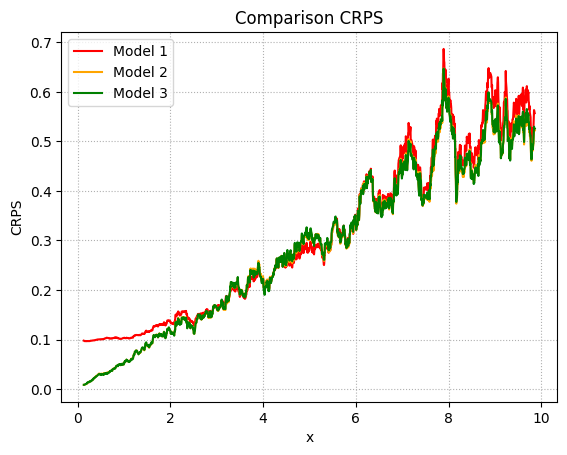

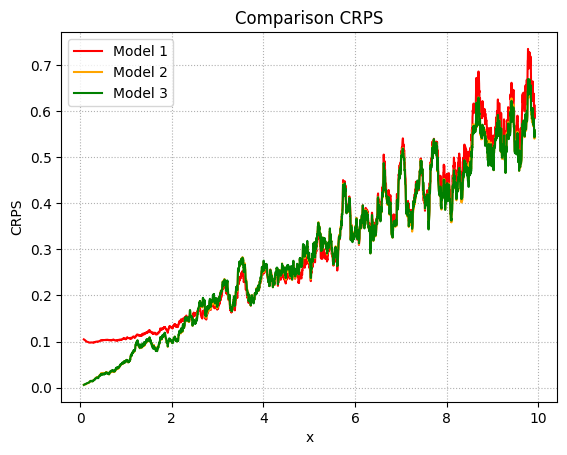

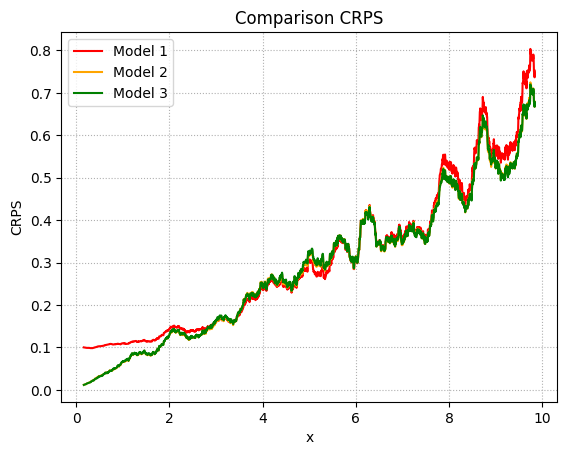

In [ ]:
# Visualize CRPS
res1 = vecCRPS(y_true=y, y_forecast=pred_mdl1)
res1 = pd.DataFrame(res1, index=x, columns=['crps', 'fcrps', 'acrps'])
res1.sort_index(inplace=True)
res1['smooth_crps'] = res1['crps'].rolling(100, center=True).mean()

res2 = vecCRPS(y_true=y, y_forecast=pred_mdl2)
res2 = pd.DataFrame(res2, index=x, columns=['crps', 'fcrps', 'acrps'])
res2.sort_index(inplace=True)
res2['smooth_crps'] = res2['crps'].rolling(100, center=True).mean()

res3 = vecCRPS(y_true=y, y_forecast=pred_mdl3)
res3 = pd.DataFrame(res3, index=x, columns=['crps', 'fcrps', 'acrps'])
res3.sort_index(inplace=True)
res3['smooth_crps'] = res3['crps'].rolling(100, center=True).mean()


plt.plot(res1.index, res1['smooth_crps'], color='red', label='Model 1')
plt.plot(res2.index, res2['smooth_crps'], color='orange', label='Model 2')
plt.plot(res2.index, res3['smooth_crps'], color='green', label='Model 3')
plt.grid(linestyle=':')
plt.title('Comparison CRPS')
plt.xlabel('x')
plt.ylabel('CRPS')
plt.legend()

/tmp/ipykernel_41/401670095.py:18: RuntimeWarning: divide by zero encountered in divide
  res_tmp = CRPS( y_forecast[i, :], y_true[i]).compute() / y_true[i]


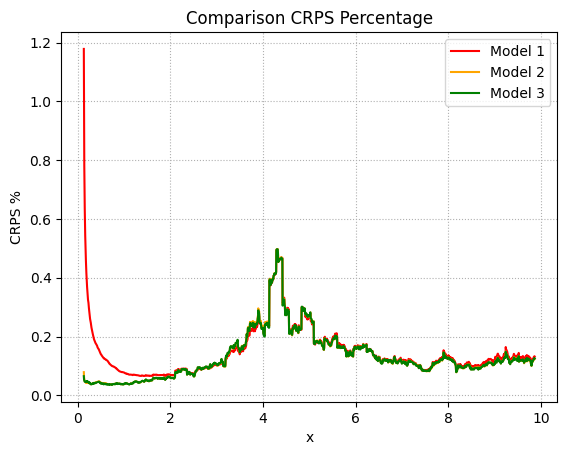

/tmp/ipykernel_41/401670095.py:18: RuntimeWarning: divide by zero encountered in divide
  res_tmp = CRPS( y_forecast[i, :], y_true[i]).compute() / y_true[i]


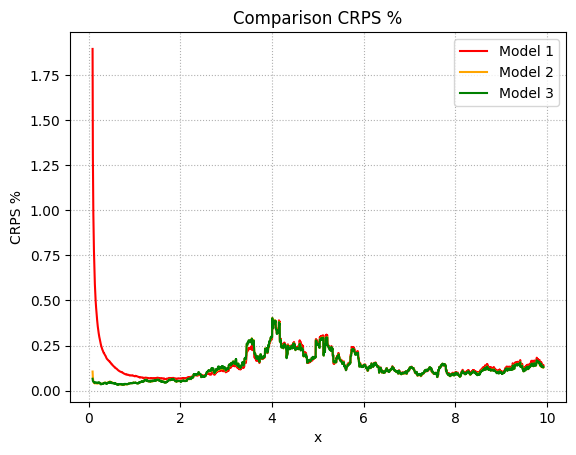

/tmp/ipykernel_37/401670095.py:18: RuntimeWarning: divide by zero encountered in divide
  res_tmp = CRPS( y_forecast[i, :], y_true[i]).compute() / y_true[i]


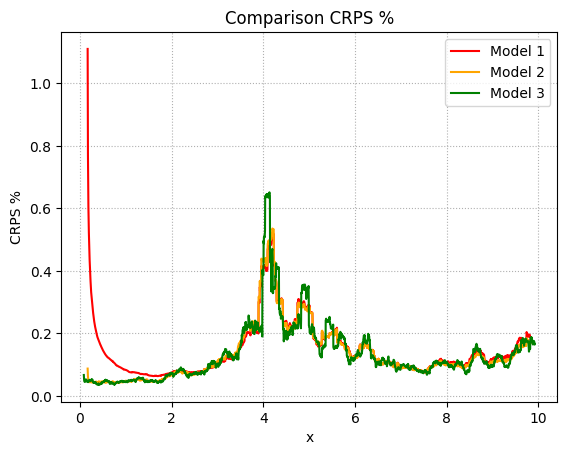

In [ ]:
# Visualize CRPS %
res1 = vecCRPSP(y_true=y, y_forecast=pred_mdl1)
res1 = pd.DataFrame(res1, index=x, columns=['crps', 'fcrps', 'acrps'])
res1.sort_index(inplace=True)
res1['smooth_crps'] = res1['crps'].rolling(100, center=True).mean()

res2 = vecCRPSP(y_true=y, y_forecast=pred_mdl2)
res2 = pd.DataFrame(res2, index=x, columns=['crps', 'fcrps', 'acrps'])
res2.sort_index(inplace=True)
res2['smooth_crps'] = res2['crps'].rolling(100, center=True).mean()

res3 = vecCRPSP(y_true=y, y_forecast=pred_mdl3)
res3 = pd.DataFrame(res3, index=x, columns=['crps', 'fcrps', 'acrps'])
res3.sort_index(inplace=True)
res3['smooth_crps'] = res3['crps'].rolling(50, center=True).mean()


plt.plot(res1.index, res1['smooth_crps'], color='red', label='Model 1')
plt.plot(res2.index, res2['smooth_crps'], color='orange', label='Model 2')
plt.plot(res2.index, res3['smooth_crps'], color='green', label='Model 3')
plt.grid(linestyle=':')
plt.title('Comparison CRPS %')
plt.xlabel('x')
plt.ylabel('CRPS %')
plt.legend()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5575bb30-6d61-4ede-84bf-e4e2be7c779e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>